In [1]:
import os, operator, itertools
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.formula.api as sm

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import nltk, string, os
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(0)

In [2]:
from Axe_Object import Axe

In [3]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [4]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price > 110 and this_axe.price < 800:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [5]:
len(axes)

10327

In [6]:
orig_prices = pd.Series([axe.price for axe in axes], name = 'prices')

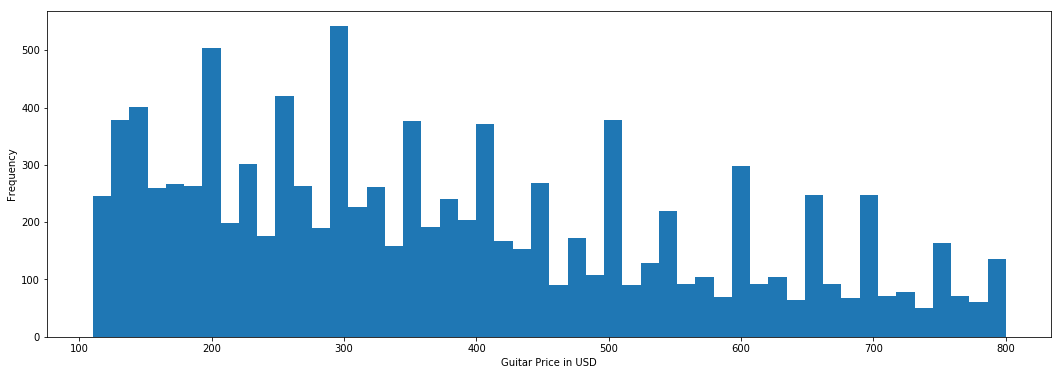

In [7]:
plt.figure(figsize = (18,6))
plt.hist(orig_prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

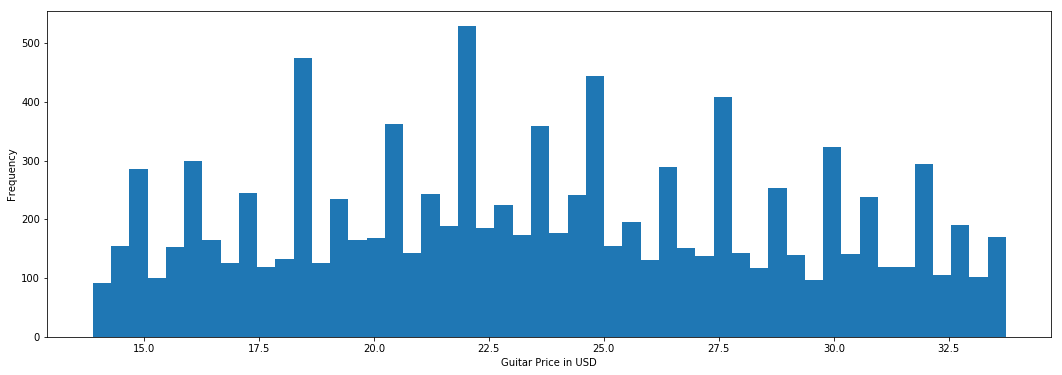

In [8]:
bxcx_lam = .4
prices = pd.Series(boxcox([axe.price for axe in axes], lmbda=bxcx_lam), name = 'prices')
plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

In [9]:
auction_duration    = pd.Series([axe.duration for axe in axes], name = 'auction_duration')
shipping_charged    = pd.Series([axe.price_shipping for axe in axes], name = 'shipping_charged')
seller_country      = pd.Series([axe.country_seller for axe in axes], name = 'seller_country')
autopay             = pd.Series([axe.autopay for axe in axes], name = 'autopay')
returns             = pd.Series([axe.returns for axe in axes], name = 'returns')
listing_type        = pd.Series([axe.listing_type for axe in axes], name = 'listing_type')
ship_type           = pd.Series([axe.ship_type for axe in axes], name = 'ship_type')
ship_expedite       = pd.Series([axe.ship_expedite for axe in axes], name = 'ship_expedite')
start_hour          = pd.cut(pd.Series([axe.start_time.hour for axe in axes], name = 'start_hour'), 6)
end_hour            = pd.cut(pd.Series([axe.end_time.hour for axe in axes], name = 'end_hour'), 6)
start_weekday       = pd.Series([axe.start_weekday for axe in axes], name = 'start_weekday').astype('category')
end_weekday         = pd.Series([axe.end_weekday for axe in axes], name = 'end_weekday').astype('category')
returns_time        = pd.Series([axe.returns_time for axe in axes], name = "returns_time").astype('category')
num_pics            = pd.Series([axe.pic_quantity for axe in axes], name = "num_pics")
brand               = pd.Series([axe.brand for axe in axes], name = "brand")
body_type           = pd.Series([axe.body_type for axe in axes], name = "body_type")
color               = pd.Series([axe.color for axe in axes], name = "color")
right_left_handed   = pd.Series([axe.right_left_handed for axe in axes], name = "right_left_handed")
best_offer_enabled  = pd.Series([axe.best_offer_enabled for axe in axes], name = "best_offer_enabled")
country_manufacture = pd.Series([axe.country_manufacture for axe in axes], name = "country_manufacture")

ship_handling_time = pd.Series([axe.ship_handling_time for axe in axes], name = 'ship_handling_time').astype('category')

string_config = pd.cut(pd.Series([axe.string_config for axe in axes], name = "string_config"),
                       [0,5,6,11,20])

seller_feedback_score = pd.cut(pd.Series([axe.seller_feedback_score for axe in axes], name = "seller_feedback_score"), [-411,0,50,100,200,500,750,1250,2500,10000,100000,400000])

seller_positive_percent = pd.cut(pd.Series([axe.seller_positive_percent for axe in axes], name = "seller_positive_percent"), [-10000,99.5,111])

model_year = pd.cut(pd.Series([axe.year for axe in axes], name = "model_year"), [1700,1975,1990,1995,2000,2005,2007,2010,2011,2012,2013,2015])

## Text as a Regression Feature

http://www-stat.wharton.upenn.edu/~stine/research/regressor.pdf

In [10]:
def assemble_guitar_document(axe):
    document = axe.title + ' '
    if axe.year != None:
        document += (str(axe.year) + ' ')
    if axe.material != None:
        document += axe.material + ' '
    if axe.model != None:
        document += axe.model + ' ' 
    if axe.brand != None:
        document += axe.brand + ' '
    if axe.subtitle != None:
        document += axe.subtitle + ' '
    if axe.condition_description != None:
        document += axe.condition_description + ' '
    if axe.description != None:
        document += axe.description
    return document

In [11]:
raw_corpus = [assemble_guitar_document(axe).lower() for axe in axes]

In [12]:
stemmer = SnowballStemmer("english")

In [13]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', ",", ".", ":", "'s", "--","’"]

In [14]:
def process_doc(doc):
    stopwords_removed = ''
    tokens = nltk.word_tokenize(doc)
    for i in range(len(tokens)):
        if tokens[i].lower() not in stopwords_list and tokens[i] not in string.punctuation:
            stopwords_removed += stemmer.stem(tokens[i]) + ' '
    return stopwords_removed

In [15]:
processed_text = pd.Series(list(map(process_doc, raw_corpus)), name = 'text') # Holding on to this while we prune below

## Assemble the Feature Set

In [16]:
y_X_dummies = pd.concat([prices, brand, color, country_manufacture, right_left_handed, best_offer_enabled, shipping_charged, 
               returns, returns_time, autopay, seller_country, ship_handling_time, listing_type, ship_expedite,
               ship_type, num_pics, auction_duration, start_hour, end_hour, start_weekday, end_weekday, 
               seller_positive_percent, model_year, body_type, string_config],
              axis = 1)

y_X = pd.get_dummies(y_X_dummies, drop_first=True)

### SPLIT

In [17]:
y_X = pd.concat([y_X, processed_text], axis=1)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(y_X.iloc[:,1:], y_X.iloc[:,0], test_size=.15)#, random_state=42)

### Scale It 

In [158]:
scaler = StandardScaler()

In [159]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,:-1]), columns=X_train.iloc[:,:-1].columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.iloc[:,:-1].columns)

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  


Text Features vectorization

In [160]:
vectorizer = TfidfVectorizer(norm=None, ngram_range=(2,3), strip_accents='ascii',
#                             max_df=0.8, min_df=2,
                             max_features=300)

vectorizer.fit(X_train['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=300, min_df=1,
        ngram_range=(2, 3), norm=None, preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [161]:
tfidf_train = vectorizer.transform(X_train['text'])
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=vectorizer.get_feature_names())

tfidf_test = vectorizer.transform(X_test['text'])
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=vectorizer.get_feature_names())

X_train_ready = pd.concat([X_train.reset_index(drop=True), tfidf_train_df], axis=1).drop('text',axis=1)
X_test_ready = pd.concat([X_test.reset_index(drop=True), tfidf_test_df], axis=1).drop('text',axis=1)

### Baseline Naive Error - Guess the Mean Price

In [162]:
price_mean = np.mean(y_train)
price_mean_vector = inv_boxcox([price_mean for i in range(len(y_test))],bxcx_lam)
baseline_error = np.sqrt(mean_squared_error(inv_boxcox(y_test, bxcx_lam), price_mean_vector))
baseline_error

188.34292820306445

### Lasso Regression

In [163]:
lin_reg = LassoCV(cv=3).fit(X_train_ready, y_train)

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

In [164]:
y_train_preds = lin_reg.predict(X_train_ready)
y_test_preds = lin_reg.predict(X_test_ready)

In [165]:
y_train_inv = inv_boxcox(y_train, bxcx_lam)
y_test_inv = inv_boxcox(y_test, bxcx_lam)
y_train_preds_inv = inv_boxcox(y_train_preds, bxcx_lam)
y_test_preds_inv = inv_boxcox(y_test_preds, bxcx_lam)

In [166]:
train_error = np.sqrt(mean_squared_error(y_train_inv, y_train_preds_inv))
test_error = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_inv))
(train_error, test_error)

(157.82101944052854, 156.89365137853378)

In [167]:
print(f'Train error is a {round((((baseline_error - train_error) / baseline_error) * 100),2)}% improvement over guessing the mean. \n')

print(f'Test error is a {round((((baseline_error - test_error) / baseline_error) * 100),2)}% improvement over guessing the mean.')

Train error is a 16.21% improvement over guessing the mean. 

Test error is a 16.7% improvement over guessing the mean.


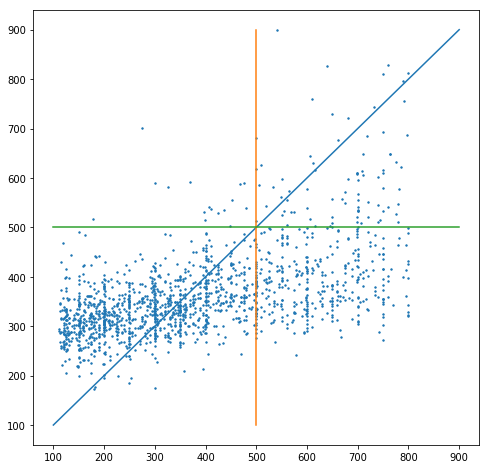

In [168]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_inv, y_test_preds_inv, s=2)
x = np.linspace(100,900, num=2)
plt.plot(x,x)
plt.plot(np.full(len(x),500),x)
plt.plot(x,np.full(len(x),500))
plt.show()

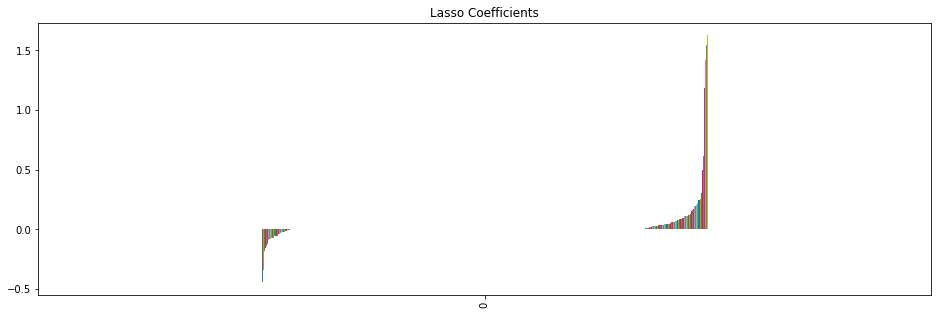

In [169]:
coef = pd.DataFrame(data = lin_reg.coef_, index=X_train_ready.columns)
model_coef = coef.sort_values(by=0).T
model_coef.plot(kind='bar', title='Lasso Coefficients', legend=False, figsize=(16,5))
plt.show()

In [170]:
t_mod = model_coef.T
lasso_feats = t_mod[abs(t_mod) > .05].dropna()
lasso_feats

,0
fender squier,-0.444149
electr guitar,-0.340458
epiphon les,-0.181432
good work,-0.153431
ship_type_Flat,-0.142548
receiv within,-0.120700
item ship,-0.088777
make sure,-0.084042
electron work,-0.083582
string electr,-0.076490


Can I get a confusion matrix?

In [171]:
price_thresh = 510

In [172]:
high_actual = y_test_inv > price_thresh

In [173]:
bad_guesses = np.full(len(y_test_inv), True)
bad_cnf_matrix = confusion_matrix(high_actual, bad_guesses)
print(f'If you just guessed every guitar would sell for more than ${price_thresh} you\'d only be right {round((bad_cnf_matrix[1][1] / (bad_cnf_matrix[1][1] + bad_cnf_matrix[0][1]))*100, 2)}% of the time.')

If you just guessed every guitar would sell for more than $510 you'd only be right 24.97% of the time.


In [174]:
high_preds = y_test_preds_inv > price_thresh

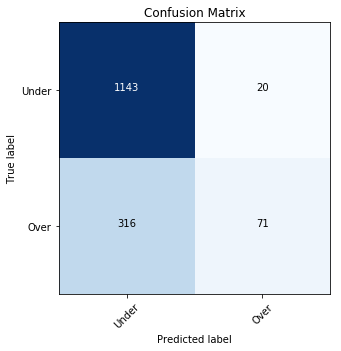

In [175]:
plt.figure(figsize=(5,5))
cnf_matrix = confusion_matrix(high_actual, high_preds)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Under', 'Over'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.show()

In [176]:
print(f'When the model guesses above ${price_thresh}, it\'s right {round((cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[0][1]))*100, 2)}% of the time.')

When the model guesses above $510, it's right 78.02% of the time.


We're trying to avoid false positives more than false negatives.

****

In [ ]:
# Cheap image analysis - white balance?

# Present Insights about time of day / day of week